## Lab #2 - Activity Detection

In this lab, we will run an activity detection example on small videos extracted from a main video. For this purpose we will:
- Pre-process the main video for splitting it in multiple small videos
- Create a video classification labeling job with Amazon SageMaker GroundTruth for going through the small videos set
- Train an actvitiy detection model on the labeled data with an Amazon SageMaker estimator, applying transfer learning with a pre-trained model from a model zoo
- Deploy the trained model to an Amazon SageMaker endpoint for performing some real-time inferences with sample videos

## Setup

#### Libraries

In [26]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import os
import json
import matplotlib.pyplot as plt
import time

#### Variables

In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'rodzanto2020ml'
#bucket = sagemaker_session.default_bucket()
task = 'football4'
videos_prefix = 'sports/football4'
label_prefix = 'sports/football4/{}'.format(task)
classes = ['highlight', 'not-highlight']
inf_prefix = '{}/validation_sample'.format(videos_prefix)
main_video = 's3://{}/sports/football1/full-match-real-madrid-vs-atletico-de-madrid-laliga-20172018.mp4'.format(bucket)

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',videos_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)
print('S3_main_video:',main_video)

Execution_role: arn:aws:iam::889960878219:role/service-role/AmazonSageMaker-ExecutionRole-20180920T165537
S3_bucket: rodzanto2020ml
Ground-truth_labeling task: football4
S3_images_prefix: sports/football4
S3_label_prefix: sports/football4/football4
Labeling_classes: ['highlight', 'not-highlight']
S3_inference_prefix: sports/football4/validation_sample
S3_main_video: s3://rodzanto2020ml/sports/football1/full-match-real-madrid-vs-atletico-de-madrid-laliga-20172018.mp4


## Pre-processing

Download the main video to be used for this lab.

`- Warning: This file' size is around 1.9GB -`

In [ ]:
s3 = boto3.resource('s3')
s3.Bucket(bucket).download_file(main_video, 'main_video.mp4')    

Split the main video into smaller chunks of video for easing the labeling and classification.

`- Warning: The following command could take a lot of time to complete depending on the size of the main video. -`

In [ ]:
!ffmpeg -i main_video.mp4 -c:v libx264 -crf 22 \
    -map 0 -segment_time 20 -reset_timestamps 1 -sc_threshold 0 -force_key_frames "expr:gte(t,n_forced*5)" \
    -f segment video_%03d.mp4

## Labeling

Create a labeling job using SageMaker Ground Truth for the sample videos. For simplicity, we will configure it such that it will only consider 2 classes.

In [1]:
#TO BE DONE...


#### Inspect labels

The "manifest file" was created after completing the labeling job using SageMaker Ground Truth. It contains metadata about the images and the associated labels.

In [8]:
# Download output.manifest from the S3 bucket to the local notebook, if it doesn't exist locally already
if not os.path.isfile('output.manifest'):
    import boto3
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file('{}/manifests/output/output.manifest'.format(label_prefix), 'output.manifest')    

Each video has a class assigned. We can read this information from the `output.manifest` file.

In [24]:
image_info = []
total0 = 0
total1 = 0
with open('output.manifest') as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))
        if json.loads(line[:-1])['{}-metadata'.format(task)]['class-name'] == 'highlight':
            total1+=1
        elif json.loads(line[:-1])['{}-metadata'.format(task)]['class-name'] == 'not_highlight':
            total0+=1

info = image_info[0]
print("Total number of videos: {}".format(len(image_info)))
print("Ground Truth labeling for sample videos:")
info

Total number of videos: 358
Ground Truth labeling for sample videos:


{'source-ref': 's3://rodzanto2020ml/sports/football4/Football4_000.mp4',
 'football4': 1,
 'football4-metadata': {'class-name': 'not_highlight',
  'job-name': 'labeling-job/football4',
  'confidence': 0,
  'type': 'groundtruth/video-classification',
  'human-annotated': 'yes',
  'creation-date': '2021-02-04T10:44:06.690503'}}

Let's check the labels distribution in the sample videos.

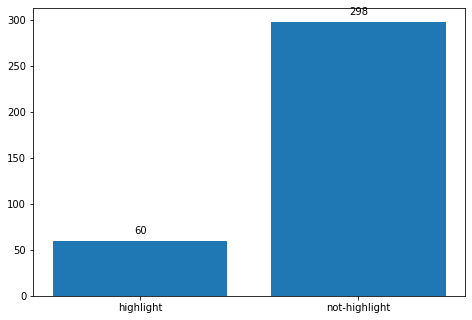

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = [total1, total0]
ax.bar(classes,labels)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom')
plt.show()

## Training using transfer learning

## Deployment and inference

#### Real-time inference

Here we deploy our model as a SageMaker endpoint for generating predictions on new sample videos.

In [48]:
predictor = mxnet_estimator.deploy(
            instance_type='ml.m5.xlarge', 
            initial_instance_count=1,
            endpoint_name=task
)

-----------!

*- Note: This step takes around 6-7 minutes to complete. -*

We have now deployed our GluonCV activity detection model in SageMaker, let's retrieve this endpoint.

In [49]:
%matplotlib inline

runtime = boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

for endpoint in  client.list_endpoints()['Endpoints']:
    if endpoint["EndpointName"] == task:
        gluoncv_endpoint = endpoint

gluoncv_endpoint

{'EndpointName': 'football2-60-od-images',
 'EndpointArn': 'arn:aws:sagemaker:eu-west-1:889960878219:endpoint/football2-60-od-images',
 'CreationTime': datetime.datetime(2021, 2, 4, 10, 49, 36, 266000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 2, 4, 10, 54, 54, 355000, tzinfo=tzlocal()),
 'EndpointStatus': 'InService'}

Finally, let's load some sample videos and pass them to the endpoint. Sample videos are available in `sample_media/`.

In [ ]:
eval_videos = glob.glob("../sample_media/*.mp4")
print('Sample videos found:',eval_videos)

for i in eval_videos:
    payload = sagemaker_session.upload_data(path=i, key_prefix=inf_prefix)
    S3_VIDEO_PATH = payload
    data = {'S3_VIDEO_PATH': S3_VIDEO_PATH,}
    print('Running inference for video',payload,'on SageMaker endpoint',task)
    print(time.time(),'Running inference for video',payload,'on SageMaker endpoint',task)
    sm-runtime = boto3.Session().client('sagemaker-runtime')
    response = sm_runtime.invoke_endpoint(EndpointName=task, ContentType='application/json',Accept='application/json',Body=json.dumps(data))
    print(time.time())
#Get and print the response
response_body = json.loads(response['Body'].read().decode('utf-8'))
print(response_body)
    

In [ ]:
print(ENDPOINT_NAME)
import time
import json
print(time.time())
sm_runtime = boto3.Session().client('sagemaker-runtime')
response = sm_runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME, ContentType='application/json',Accept='application/json',Body=json.dumps(data1))
print(time.time())
#Get and print the response
response_body = json.loads(response['Body'].read().decode('utf-8'))
print(response_body)